# **Point Net - Classification**

In this notebook, we will use the classification version of point net to classify objects from the shapenet dataset

In [1]:
import os
import sys
import re
from glob import glob
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn.functional import kl_div


import open3d as o3

import yaml
import argparse

import torch_geometric.transforms as T
from torch_geometric.datasets import ModelNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, fps, global_max_pool, radius
from torch_geometric.nn.conv import PointConv

#from open3d.web_visualizer import draw # for non Colab
#sys.path.append('../../PointNet-VAE/src')
sys.path.append('../src')

from models.utils import PointsTo3DShape
from models.PointNetEncoder import PointNetBackbone
from utils.calculate_loss import ChamferDistanceLoss
from models.PointCloudEncoder import PointCloudEncoder
from models.PointCloudDecoder import PointCloudDecoder, PointCloudDecoderSelf, PointCloudDecoderMLP
from models.AutoEncoder import AutoEncoder
from models.VAE import VAE
from data.dataset import DataModelNet
from utils.utils import *
from evaluation.evaluate import Evaluater
from utils.train import *

from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# TEMP for supressing pytorch user warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
print('MPS is build: {}'.format(torch.backends.mps.is_built()))
print('MPS Availability: {}'.format(torch.backends.mps.is_available()))
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps'
print('Device is set to :{}'.format(DEVICE))
#torch.set_default_device(DEVICE)
torch.seed = 42

MPS is build: True
MPS Availability: True
Device is set to :mps


### Get the data

In [4]:
# General parameters
#NUM_TRAIN_POINTS = 8192
NUM_TEST_POINTS = 1024

NUM_POINTS = 1024
NUM_CLASSES = 16

# model hyperparameters
BATCH_SIZE = 32

EPOCHS = 1000
LR = 0.0001
REG_WEIGHT = 0.001 

LATENT_DIM = 128

Helpers for our dataset

In [5]:
with open('../configs/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [6]:
data = DataModelNet(data_path="../../data/ModelNet10",
                    pre_transform= T.NormalizeScale(),
                    train_batch_size= 16,
                    val_batch_size=  16,
                    train_num_points= 1024,
                    val_num_points= 1024,
)

In [7]:
data.setup()
train_loader = data.train_dataloader()
val_loader = data.val_dataloader()

In [8]:
encoder = PointCloudEncoder(latent_dim=LATENT_DIM, num_point=NUM_POINTS).to(DEVICE)
#encoder = PointNetBackbone(num_points=NUM_POINTS, num_global_feats=LATENT_DIM, local_feat=False).to(DEVICE)
decoder = PointCloudDecoderMLP(latent_dim=LATENT_DIM, num_hidden=3, num_point=NUM_POINTS).to(DEVICE)
autoencoder = AutoEncoder(encoder, decoder, device=DEVICE, latent_dim=LATENT_DIM).to(DEVICE)
vae = VAE(encoder, decoder, device=DEVICE, latent_dim=LATENT_DIM).to(DEVICE)

In [9]:
from utils.train import Trainer

model_run = Trainer(model=vae, 
                    criterion=ChamferDistanceLoss(),
                    optimizer=optim.Adam(vae.parameters(), config['trainer_parameters']['lr']),
                    **config['model_parameters']
                    )

In [10]:
points, _, _ = model_run._sanitizer(next(iter(train_loader)))
PointsTo3DShape(points[0][0].squeeze())


In [13]:
points = points.to(config['model_parameters']['device'])
global_features, _, _ = model_run.model.encoder(points)
mu = model_run.model.fc_mu(global_features)
logvar = model_run.model.fc_logvar(global_features)
mu = torch.randn((10000, 128))
logvar = torch.randn((10000, 128))

#mu = torch.zeros_like(mu)
#logvar = torch.zeros_like(logvar)
print(mu.mean())
print(logvar.mean())

model_run.model.reparameterize(mu, logvar)


tensor(5.2846e-05)
tensor(-0.0019)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!

(array([ 1.,  4., 11., 21., 24., 25., 21., 15.,  5.,  1.]),
 array([-2.85373592, -2.27853012, -1.70332456, -1.12811875, -0.55291307,
         0.02229261,  0.5974983 ,  1.17270398,  1.74790978,  2.32311535,
         2.89832115]),
 <BarContainer object of 10 artists>)

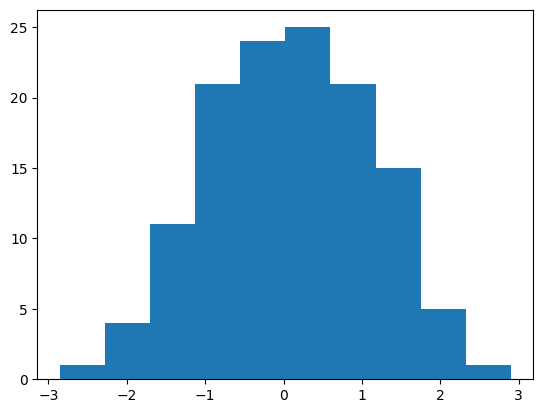

In [14]:
plt.hist(mu[0].numpy())

In [ ]:
torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
# sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))
# KL(P || Q) = – sum x in X P(x) * log(Q(x) / P(x))


In [ ]:
model_run.fit(train_loader, val_loader, 100)

# END OF TRAINING CYCLE

In [ ]:
model_evaluate = Evaluater(
        model=vae,
        criterion=ChamferDistanceLoss(),
        encoder_type='ConvolutionEncoder',
        model_type='VAE',
        checkpoint='../models/checkpoints/trial/checkpoint_499.pth',
        device='mps',
        )

In [ ]:
points, reconstructed_x = model_evaluate.evaluate_data(next(iter(val_loader)))

In [ ]:
N=30
PointsTo3DShape(points[N].squeeze().cpu())


In [ ]:
PointsTo3DShape(reconstructed_x[N].cpu())


In [ ]:
import pyvista as pv
point_cloud = pv.PolyData(reconstructed_x[N].cpu().numpy())
mesh = point_cloud.reconstruct_surface()
mesh.plot(color='orange')
